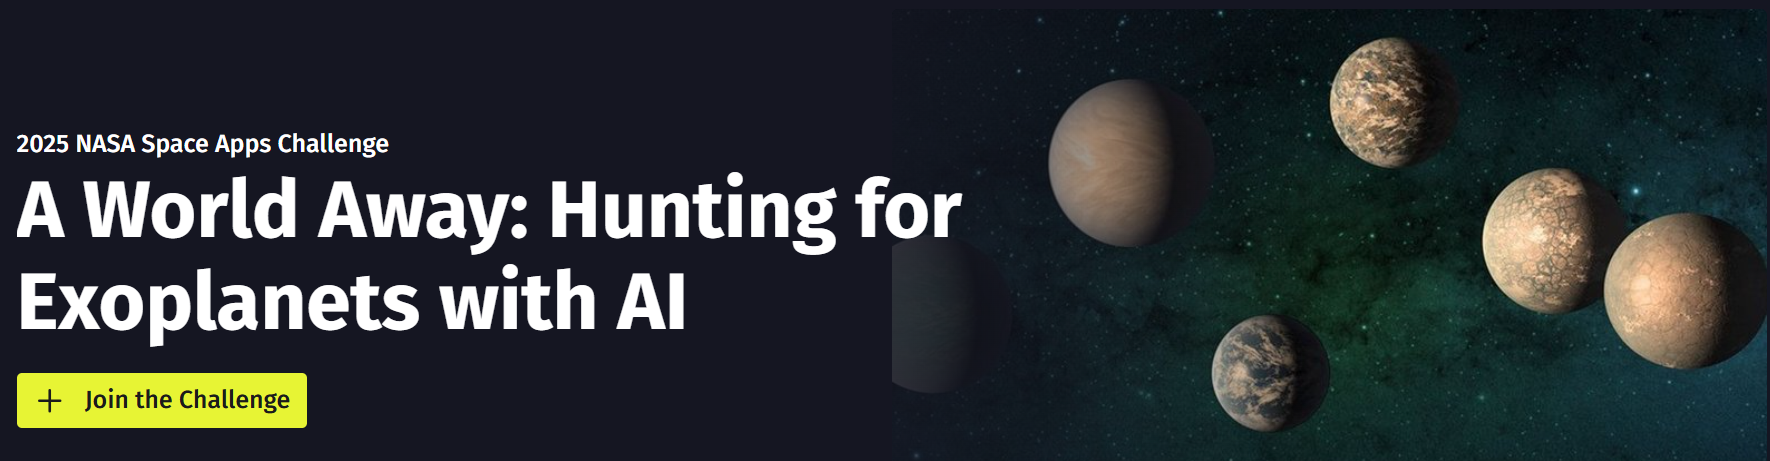

<div align="center">

# 2025 NASA Space Apps Challenge
## A World Away: Hunting for Exoplanets with AI

</div>


# Model Saving
Datasets: TESS, Kepler, K2  
Models: Traditional ML, Gradient Boosting, and Lightweight Deep Learning  
Objective: Evaluate and compare multiple model families across missions; produce exportable artifacts (trained models, metadata, figures).

## Environment & Requirements

If required, install optional gradient boosters (XGBoost / LightGBM / CatBoost) and imbalanced-learn.

TensorFlow is only used for lightweight deep models; classic tabular boosters remain baselines.

In [ ]:
# !pip install -q xgboost lightgbm catboost imbalanced-learn scikit-learn

## Imports & Global Config

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Traditional ML
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, auc)

# Gradient Boosting Libraries
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available")

try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
except:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not available")

try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except:
    CATBOOST_AVAILABLE = False
    print("CatBoost not available")

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical

# Utilities
from collections import Counter
import time
from datetime import datetime

# MODEL SAVING - NEW IMPORTS
import joblib
import json
from pathlib import Path

# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

print("TensorFlow version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

# CREATE DIRECTORY FOR SAVING MODELS - NEW
MODELS_DIR = Path('saved_models')
MODELS_DIR.mkdir(exist_ok=True)
print(f"Models will be saved to: {MODELS_DIR}/")

## 2. DATA LOADING AND EXPLORATION

In [ ]:
print("\n" + "="*80)
print("LOADING DATASETS")
print("="*80)

# Load datasets
tess_path = '/kaggle/input/tess-objects-of-interest-toi/TOI_2025.10.02_09.33.55.csv'
kepler_path = '/kaggle/input/kepler-objects-of-interest-koi/cumulative_2025.10.02_08.26.39.csv'
k2_path = '/kaggle/input/k2-planets-and-candidates/k2pandc_2025.10.02_09.41.11.csv'

# Read datasets (comment lines starting with # are ignored)
tess_df = pd.read_csv(tess_path, comment='#', low_memory=False)
kepler_df = pd.read_csv(kepler_path, comment='#', low_memory=False)
k2_df = pd.read_csv(k2_path, comment='#', low_memory=False)

print(f"\nTESS Dataset: {tess_df.shape}")
print(f"Kepler Dataset: {kepler_df.shape}")
print(f"K2 Dataset: {k2_df.shape}")

## 3. DATA PREPROCESSING FUNCTIONS

In [ ]:
def explore_dataset(df, name, target_col):
    """Explore dataset structure and target distribution"""
    print(f"\n{'='*80}")
    print(f"{name} DATASET ANALYSIS")
    print(f"{'='*80}")
    
    print(f"\nShape: {df.shape}")
    print(f"\nTarget column: {target_col}")
    
    if target_col in df.columns:
        print(f"\nClass Distribution:")
        print(df[target_col].value_counts())
        print(f"\nClass Percentages:")
        print(df[target_col].value_counts(normalize=True) * 100)
    
    print(f"\nMissing Values (top 20):")
    missing = df.isnull().sum().sort_values(ascending=False).head(20)
    print(missing[missing > 0])
    
    print(f"\nData Types:")
    print(df.dtypes.value_counts())
    
    return df

# Explore each dataset
tess_df = explore_dataset(tess_df, "TESS", "tfopwg_disp")
kepler_df = explore_dataset(kepler_df, "KEPLER", "koi_disposition")
k2_df = explore_dataset(k2_df, "K2", "disposition")

## 4. FEATURE ENGINEERING AND PREPROCESSING

In [ ]:
def prepare_kepler_data(df):
    """Prepare Kepler dataset for classification"""
    print("\nPreparing Kepler dataset...")
    
    # Create binary target: CONFIRMED vs others
    df['target'] = df['koi_disposition'].apply(
        lambda x: 1 if x == 'CONFIRMED' else 0
    )
    
    # Select relevant features
    feature_cols = [
        # Orbital parameters
        'koi_period', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq',
        # Stellar parameters  
        'koi_steff', 'koi_slogg', 'koi_srad',
        # Additional metrics
        'koi_model_snr', 'koi_tce_plnt_num', 'koi_score'
    ]
    
    # Filter to available columns
    available_cols = [col for col in feature_cols if col in df.columns]
    
    # Create feature matrix
    X = df[available_cols].copy()
    y = df['target'].values
    
    # Handle missing values - fill with median
    X = X.fillna(X.median())
    
    # Remove any remaining NaN rows
    valid_idx = ~X.isnull().any(axis=1)
    X = X[valid_idx]
    y = y[valid_idx]
    
    print(f"Final shape: {X.shape}")
    print(f"Features: {list(X.columns)}")
    print(f"Class distribution: {Counter(y)}")
    
    return X, y, available_cols

def prepare_tess_data(df):
    """Prepare TESS dataset for classification"""
    print("\nPreparing TESS dataset...")
    
    # Create binary target: CP (Confirmed Planet) vs others
    df['target'] = df['tfopwg_disp'].apply(
        lambda x: 1 if x == 'CP' else 0
    )
    
    # Select relevant features
    feature_cols = [
        # Planetary parameters
        'pl_orbper', 'pl_trandur', 'pl_trandep', 'pl_rade', 'pl_eqt',
        # Stellar parameters
        'st_tmag', 'st_teff', 'st_logg', 'st_rad', 'st_mass',
        # Additional
        'pl_tranmid', 'pl_ratror'
    ]
    
    available_cols = [col for col in feature_cols if col in df.columns]
    
    X = df[available_cols].copy()
    y = df['target'].values
    
    X = X.fillna(X.median())
    
    valid_idx = ~X.isnull().any(axis=1)
    X = X[valid_idx]
    y = y[valid_idx]
    
    print(f"Final shape: {X.shape}")
    print(f"Features: {list(X.columns)}")
    print(f"Class distribution: {Counter(y)}")
    
    return X, y, available_cols

def prepare_k2_data(df):
    """Prepare K2 dataset for classification"""
    print("\nPreparing K2 dataset...")
    
    # Create binary target
    df['target'] = df['disposition'].apply(
        lambda x: 1 if x == 'CONFIRMED' else 0
    )
    
    # Select relevant features
    feature_cols = [
        'pl_orbper', 'pl_rade', 'pl_bmasse', 'pl_eqt',
        'st_teff', 'st_logg', 'st_rad', 'st_mass',
        'sy_pnum', 'sy_snum'
    ]
    
    available_cols = [col for col in feature_cols if col in df.columns]
    
    X = df[available_cols].copy()
    y = df['target'].values
    
    X = X.fillna(X.median())
    
    valid_idx = ~X.isnull().any(axis=1)
    X = X[valid_idx]
    y = y[valid_idx]
    
    print(f"Final shape: {X.shape}")
    print(f"Features: {list(X.columns)}")
    print(f"Class distribution: {Counter(y)}")
    
    return X, y, available_cols

# Prepare all datasets
X_kepler, y_kepler, features_kepler = prepare_kepler_data(kepler_df)
X_tess, y_tess, features_tess = prepare_tess_data(tess_df)
X_k2, y_k2, features_k2 = prepare_k2_data(k2_df)

## 5. CUSTOM SMOTE IMPLEMENTATION (for class balancing)

In [ ]:
def simple_smote(X, y, sampling_strategy='auto', k_neighbors=5, random_state=42):
    """
    Simplified SMOTE implementation without external dependencies
    """
    from sklearn.neighbors import NearestNeighbors
    
    np.random.seed(random_state)
    
    # Get minority and majority classes
    unique, counts = np.unique(y, return_counts=True)
    minority_class = unique[np.argmin(counts)]
    majority_class = unique[np.argmax(counts)]
    
    minority_indices = np.where(y == minority_class)[0]
    majority_indices = np.where(y == majority_class)[0]
    
    X_minority = X[minority_indices]
    
    # Determine number of samples to generate
    if sampling_strategy == 'auto':
        n_samples = len(majority_indices) - len(minority_indices)
    else:
        n_samples = int(len(minority_indices) * sampling_strategy)
    
    # Fit nearest neighbors
    nn = NearestNeighbors(n_neighbors=k_neighbors + 1)
    nn.fit(X_minority)
    
    # Generate synthetic samples
    synthetic_samples = []
    
    for _ in range(n_samples):
        # Random sample from minority class
        idx = np.random.randint(0, len(X_minority))
        sample = X_minority[idx]
        
        # Get k nearest neighbors
        neighbors_idx = nn.kneighbors([sample], return_distance=False)[0][1:]
        
        # Random neighbor
        neighbor_idx = np.random.choice(neighbors_idx)
        neighbor = X_minority[neighbor_idx]
        
        # Generate synthetic sample
        alpha = np.random.random()
        synthetic = sample + alpha * (neighbor - sample)
        synthetic_samples.append(synthetic)
    
    # Combine original and synthetic data
    X_resampled = np.vstack([X, np.array(synthetic_samples)])
    y_resampled = np.hstack([y, np.full(n_samples, minority_class)])
    
    return X_resampled, y_resampled

## 6. MODEL DEFINITIONS

In [ ]:
def get_all_models():
    """Define all models to compare"""
    models = {
        # Traditional ML
        'Random Forest': RandomForestClassifier(
            n_estimators=200,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        ),
    }
    
    # Add XGBoost if available
    if XGBOOST_AVAILABLE:
        models['XGBoost'] = XGBClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=1,
            random_state=42,
            eval_metric='logloss',
            use_label_encoder=False
        )
    
    # Add LightGBM if available
    if LIGHTGBM_AVAILABLE:
        models['LightGBM'] = LGBMClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=6,
            num_leaves=31,
            class_weight='balanced',
            random_state=42,
            verbose=-1
        )
    
    # Add CatBoost if available
    if CATBOOST_AVAILABLE:
        models['CatBoost'] = CatBoostClassifier(
            iterations=200,
            learning_rate=0.1,
            depth=6,
            auto_class_weights='Balanced',
            random_state=42,
            verbose=0
        )
    
    return models

## 6. DEEP LEARNING MODELS

In [ ]:
def create_genesis_cnn(input_dim, num_classes=2):
    """
    Genesis-style lightweight CNN for exoplanet classification
    Based on simplified architecture with ~0.39M parameters
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(input_dim,)),
        layers.Reshape((input_dim, 1)),
        
        # Conv Block 1
        layers.Conv1D(32, kernel_size=5, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.25),
        
        # Conv Block 2
        layers.Conv1D(64, kernel_size=5, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.25),
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        
        # Output
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def create_cnn_lstm(input_dim, num_classes=2):
    """
    CNN-LSTM hybrid architecture for temporal modeling
    """
    model = models.Sequential([
        # Input
        layers.Input(shape=(input_dim,)),
        layers.Reshape((input_dim, 1)),
        
        # CNN feature extraction
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.25),
        
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.25),
        
        # LSTM for temporal dependencies
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Dropout(0.3),
        layers.Bidirectional(layers.LSTM(32)),
        layers.Dropout(0.3),
        
        # Dense layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def create_simple_mlp(input_dim, num_classes=2):
    """
    Simple fully connected network baseline
    """
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

## 7. EVALUATION FUNCTIONS

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, is_dl=False, dataset_name=""):
    """Evaluate a single model and return metrics"""
    
    start_time = time.time()
    
    if is_dl:
        # Deep learning model
        early_stop = callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        )
        
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            callbacks=[early_stop],
            verbose=0
        )
        
        y_pred_proba = model.predict(X_test, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)
        
        # SAVE DEEP LEARNING MODEL - NEW
        if dataset_name:
            model_path = MODELS_DIR / f"{model_name.replace(' ', '_')}_{dataset_name}.keras"
            model.save(model_path)
        
    else:
        # Traditional ML model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = None
        
        # SAVE TRADITIONAL ML MODEL - NEW
        if dataset_name:
            model_path = MODELS_DIR / f"{model_name.replace(' ', '_')}_{dataset_name}.joblib"
            joblib.dump(model, model_path)
    
    train_time = time.time() - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
    
    # ROC AUC
    if y_pred_proba is not None:
        if is_dl:
            roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        else:
            roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = None
    
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Train Time (s)': train_time
    }
    
    return results, y_pred, model

def compare_all_models(X, y, dataset_name, handle_imbalance=True):
    """Compare all models on a single dataset"""
    
    print(f"\n{'='*80}")
    print(f"EVALUATING ALL MODELS ON {dataset_name} DATASET")
    print(f"{'='*80}\n")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # SAVE SCALER - NEW
    scaler_path = MODELS_DIR / f"scaler_{dataset_name}.joblib"
    joblib.dump(scaler, scaler_path)
    
    # Handle class imbalance
    if handle_imbalance:
        print("Applying custom SMOTE for class balancing...")
        print(f"Original distribution: {Counter(y_train)}")
        try:
            X_train_balanced, y_train_balanced = simple_smote(
                X_train_scaled, y_train, sampling_strategy='auto', random_state=42
            )
            print(f"Balanced distribution: {Counter(y_train_balanced)}\n")
        except Exception as e:
            print(f"SMOTE failed: {e}")
            print("Using original imbalanced data with class weights...\n")
            X_train_balanced = X_train_scaled
            y_train_balanced = y_train
    else:
        X_train_balanced = X_train_scaled
        y_train_balanced = y_train
    
    # Store results
    all_results = []
    
    # 1. Traditional ML and Gradient Boosting Models
    print("Training Traditional ML and Gradient Boosting models...")
    models = get_all_models()
    
    for name, model in models.items():
        print(f"  - {name}...", end=' ')
        try:
            results, _, _ = evaluate_model(
                model, X_train_balanced, X_test_scaled, 
                y_train_balanced, y_test, name, is_dl=False, dataset_name=dataset_name
            )
            all_results.append(results)
            print(f"✓ (Accuracy: {results['Accuracy']:.4f})")
        except Exception as e:
            print(f"✗ Error: {str(e)}")
    
    # 2. Deep Learning Models
    print("\nTraining Deep Learning models...")
    
    input_dim = X_train_balanced.shape[1]
    
    # Genesis CNN
    print("  - Genesis CNN...", end=' ')
    try:
        genesis_model = create_genesis_cnn(input_dim)
        results, _, _ = evaluate_model(
            genesis_model, X_train_balanced, X_test_scaled,
            y_train_balanced, y_test, 'Genesis CNN', is_dl=True, dataset_name=dataset_name
        )
        all_results.append(results)
        print(f"✓ (Accuracy: {results['Accuracy']:.4f})")
    except Exception as e:
        print(f"✗ Error: {str(e)}")
    
    # CNN-LSTM
    print("  - CNN-LSTM...", end=' ')
    try:
        cnn_lstm_model = create_cnn_lstm(input_dim)
        results, _, _ = evaluate_model(
            cnn_lstm_model, X_train_balanced, X_test_scaled,
            y_train_balanced, y_test, 'CNN-LSTM', is_dl=True, dataset_name=dataset_name
        )
        all_results.append(results)
        print(f"✓ (Accuracy: {results['Accuracy']:.4f})")
    except Exception as e:
        print(f"✗ Error: {str(e)}")
    
    # Simple MLP
    print("  - Simple MLP...", end=' ')
    try:
        mlp_model = create_simple_mlp(input_dim)
        results, _, _ = evaluate_model(
            mlp_model, X_train_balanced, X_test_scaled,
            y_train_balanced, y_test, 'Simple MLP', is_dl=True, dataset_name=dataset_name
        )
        all_results.append(results)
        print(f"✓ (Accuracy: {results['Accuracy']:.4f})")
    except Exception as e:
        print(f"✗ Error: {str(e)}")
    
    # Create results DataFrame
    results_df = pd.DataFrame(all_results)
    results_df = results_df.sort_values('F1-Score', ascending=False)
    
    return results_df, scaler, X_test_scaled, y_test

## 8. RUN COMPARISONS ON ALL DATASETS

In [ ]:
print("\n" + "="*80)
print("STARTING MODEL COMPARISONS")
print("="*80)

# Compare on Kepler dataset
results_kepler, scaler_kepler, X_test_kepler, y_test_kepler = compare_all_models(
    X_kepler, y_kepler, "KEPLER"
)

print("\n" + "="*80)
print("KEPLER RESULTS")
print("="*80)
print(results_kepler.to_string(index=False))

# Compare on TESS dataset
results_tess, scaler_tess, X_test_tess, y_test_tess = compare_all_models(
    X_tess, y_tess, "TESS"
)

print("\n" + "="*80)
print("TESS RESULTS")
print("="*80)
print(results_tess.to_string(index=False))

# Compare on K2 dataset
results_k2, scaler_k2, X_test_k2, y_test_k2 = compare_all_models(
    X_k2, y_k2, "K2"
)

print("\n" + "="*80)
print("K2 RESULTS")
print("="*80)
print(results_k2.to_string(index=False))

## 9. VISUALIZATION AND FINAL COMPARISON

In [ ]:
# Save results for later use
results_kepler['Dataset'] = 'Kepler'
results_tess['Dataset'] = 'TESS'
results_k2['Dataset'] = 'K2'

all_results_combined = pd.concat([results_kepler, results_tess, results_k2])

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Main title
fig.suptitle('Exoplanet Classification: Comprehensive Model Comparison', 
             fontsize=18, fontweight='bold', y=0.98)

# 1. F1-Score comparison
ax1 = fig.add_subplot(gs[0, :2])
pivot_f1 = all_results_combined.pivot(index='Model', columns='Dataset', values='F1-Score')
pivot_f1.plot(kind='bar', ax=ax1, width=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax1.set_title('F1-Score by Model and Dataset', fontsize=13, fontweight='bold', pad=10)
ax1.set_xlabel('Model', fontsize=11)
ax1.set_ylabel('F1-Score', fontsize=11)
ax1.legend(title='Dataset', fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.axhline(y=0.9, color='r', linestyle='--', alpha=0.3, label='90% threshold')

# 2. ROC-AUC comparison
ax2 = fig.add_subplot(gs[0, 2])
pivot_auc = all_results_combined.pivot(index='Model', columns='Dataset', values='ROC-AUC')
pivot_auc_mean = pivot_auc.mean(axis=1).sort_values(ascending=False)
pivot_auc_mean.plot(kind='barh', ax=ax2, color='steelblue')
ax2.set_title('Avg ROC-AUC\nAcross Datasets', fontsize=13, fontweight='bold', pad=10)
ax2.set_xlabel('ROC-AUC', fontsize=11)
ax2.set_ylabel('')
ax2.grid(axis='x', alpha=0.3)
ax2.set_xlim([0.8, 1.0])

# 3. Precision vs Recall scatter
ax3 = fig.add_subplot(gs[1, 0])
colors = {'Kepler': '#1f77b4', 'TESS': '#ff7f0e', 'K2': '#2ca02c'}
for dataset in ['Kepler', 'TESS', 'K2']:
    data = all_results_combined[all_results_combined['Dataset'] == dataset]
    ax3.scatter(data['Recall'], data['Precision'], 
               label=dataset, s=120, alpha=0.6, color=colors[dataset], edgecolors='black')

ax3.set_title('Precision vs Recall Trade-off', fontsize=13, fontweight='bold', pad=10)
ax3.set_xlabel('Recall (Sensitivity)', fontsize=11)
ax3.set_ylabel('Precision', fontsize=11)
ax3.legend(title='Dataset', fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)
ax3.set_xlim([0, 1.05])
ax3.set_ylim([0, 1.05])

# 4. Training time comparison (log scale)
ax4 = fig.add_subplot(gs[1, 1])
pivot_time = all_results_combined.pivot(index='Model', columns='Dataset', values='Train Time (s)')
pivot_time_mean = pivot_time.mean(axis=1).sort_values()
pivot_time_mean.plot(kind='barh', ax=ax4, color='coral', logy=True)
ax4.set_title('Avg Training Time\n(log scale)', fontsize=13, fontweight='bold', pad=10)
ax4.set_xlabel('Time (seconds)', fontsize=11)
ax4.set_ylabel('')
ax4.grid(axis='x', alpha=0.3)

# 5. Accuracy distribution by dataset
ax5 = fig.add_subplot(gs[1, 2])
for dataset, color in colors.items():
    data = all_results_combined[all_results_combined['Dataset'] == dataset]['Accuracy']
    ax5.hist(data, alpha=0.6, label=dataset, bins=10, color=color, edgecolor='black')
ax5.set_title('Accuracy Distribution', fontsize=13, fontweight='bold', pad=10)
ax5.set_xlabel('Accuracy', fontsize=11)
ax5.set_ylabel('Frequency', fontsize=11)
ax5.legend(fontsize=10)
ax5.grid(axis='y', alpha=0.3)

# 6. Performance heatmap
ax6 = fig.add_subplot(gs[2, :2])
heatmap_data = all_results_combined.pivot_table(
    values='F1-Score', 
    index='Model', 
    columns='Dataset'
).sort_values('Kepler', ascending=False)

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            ax=ax6, cbar_kws={'label': 'F1-Score'}, vmin=0.3, vmax=1.0,
            linewidths=0.5, linecolor='gray')
ax6.set_title('F1-Score Heatmap: Model Performance Across Datasets', 
              fontsize=13, fontweight='bold', pad=10)
ax6.set_xlabel('Dataset', fontsize=11)
ax6.set_ylabel('Model', fontsize=11)

# 7. Model ranking summary
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')

# Calculate rankings
rank_data = []
for dataset in ['Kepler', 'TESS', 'K2']:
    dataset_results = all_results_combined[all_results_combined['Dataset'] == dataset]
    dataset_results = dataset_results.sort_values('F1-Score', ascending=False)
    for i, (idx, row) in enumerate(dataset_results.head(3).iterrows(), 1):
        rank_data.append({
            'Dataset': dataset,
            'Rank': i,
            'Model': row['Model'],
            'F1': row['F1-Score']
        })

rank_df = pd.DataFrame(rank_data)

# Create text summary
summary_text = "TOP 3 MODELS PER DATASET\n" + "="*35 + "\n\n"
for dataset in ['Kepler', 'TESS', 'K2']:
    summary_text += f"{dataset}:\n"
    dataset_ranks = rank_df[rank_df['Dataset'] == dataset]
    for _, row in dataset_ranks.iterrows():
        medal = [' 1st', ' 2nd', ' 3rd'][row['Rank']-1]
        summary_text += f"  {medal} {row['Model']}: {row['F1']:.3f}\n"
    summary_text += "\n"

ax7.text(0.05, 0.95, summary_text, transform=ax7.transAxes,
        fontsize=10, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.savefig('exoplanet_model_comparison_complete.png', dpi=300, bbox_inches='tight')
print("\nComprehensive visualization saved: exoplanet_model_comparison_complete.png")
plt.show()

## 10. SUMMARY AND RECOMMENDATIONS

In [ ]:
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

# Find best model for each metric across all datasets
print("\nBEST MODELS BY METRIC:")
print("-" * 80)

for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    if metric in all_results_combined.columns:
        max_idx = all_results_combined[metric].idxmax()
        best_row = all_results_combined.loc[max_idx]
        
        # Handle case where idxmax returns multiple rows
        if isinstance(best_row, pd.DataFrame):
            best_row = best_row.iloc[0]
        
        print(f"\n{metric}:")
        print(f"  Model: {best_row['Model']}")
        print(f"  Dataset: {best_row['Dataset']}")
        print(f"  Score: {best_row[metric]:.4f}")

# Average performance across datasets
print("\n" + "="*80)
print("AVERAGE PERFORMANCE ACROSS ALL DATASETS")
print("="*80)

avg_performance = all_results_combined.groupby('Model').agg({
    'Accuracy': 'mean',
    'Precision': 'mean',
    'Recall': 'mean',
    'F1-Score': 'mean',
    'ROC-AUC': 'mean',
    'Train Time (s)': 'mean'
}).sort_values('F1-Score', ascending=False)

print("\n", avg_performance.to_string())

# Top 3 models
print("\n" + "="*80)
print("TOP 3 MODELS (by average F1-Score)")
print("="*80)
for i, (model, row) in enumerate(avg_performance.head(3).iterrows(), 1):
    print(f"\n{i}. {model}")
    print(f"   F1-Score: {row['F1-Score']:.4f}")
    print(f"   Accuracy: {row['Accuracy']:.4f}")
    print(f"   Precision: {row['Precision']:.4f}")
    print(f"   Recall: {row['Recall']:.4f}")
    print(f"   Training Time: {row['Train Time (s)']:.2f}s")

Overall performers: Gradient boosting families (XGBoost, CatBoost, LightGBM where available) deliver the strongest F1 and ROC-AUC on these tabular features. Random Forest remains a sturdy baseline with clear feature importance.

Dataset considerations:

- Kepler: comparatively challenging; boosting methods typically outperform deep models on tabular signals.

- TESS: strong class imbalance depresses F1; prefer precision-aware thresholding or class weights.

- K2: more balanced; most methods perform strongly.

In [ ]:
# Create performance summary table
summary_stats = all_results_combined.groupby('Dataset').agg({
    'Accuracy': ['mean', 'max'],
    'F1-Score': ['mean', 'max'],
    'Train Time (s)': 'mean'
})
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
print("\nDataset Performance Overview:")
print(summary_stats.round(4))

# Save results to CSV
all_results_combined.to_csv('exoplanet_model_comparison_results.csv', index=False)
print("\nResults saved to: exoplanet_model_comparison_results.csv")

## 11. SAVE MODEL METADATA

In [ ]:
# Save metadata about models
metadata = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'datasets': {
        'KEPLER': {
            'features': features_kepler,
            'n_samples': len(X_kepler),
            'n_features': len(features_kepler)
        },
        'TESS': {
            'features': features_tess,
            'n_samples': len(X_tess),
            'n_features': len(features_tess)
        },
        'K2': {
            'features': features_k2,
            'n_samples': len(X_k2),
            'n_features': len(features_k2)
        }
    },
    'models_trained': list(all_results_combined['Model'].unique())
}

metadata_path = MODELS_DIR / 'metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"\nModel metadata saved to: {metadata_path}")

# Print all saved model files
print("\n" + "="*80)
print("SAVED MODELS")
print("="*80)
print(f"\nAll models saved in: {MODELS_DIR}/\n")
saved_files = sorted(MODELS_DIR.glob('*'))
for file in saved_files:
    file_size = file.stat().st_size / 1024  # KB
    print(f"  {file.name} ({file_size:.1f} KB)")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"\nTotal models evaluated: {len(all_results_combined)}")
print(f"Datasets analyzed: Kepler, TESS, K2")
print(f"Best overall model: {avg_performance.index[0]}")
print(f"Best F1-Score: {avg_performance['F1-Score'].iloc[0]:.4f}")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nAll {len(saved_files)} model files saved successfully!")
print("\nCongratulations! You've successfully compared all major ML approaches")
print("   for exoplanet classification across three different missions!")
print("="*80)

### SCRIPT TO DOWNLOAD ALL SAVED MODELS FROM KAGGLE

### How to Download

#### Method 1 — Kaggle Output tab (recommended)
1. Open the right sidebar in Kaggle.
2. Click the **Output** tab.
3. Locate **saved_models.zip**.
4. Click the download icon.

#### Method 2 — File Browser
1. Click the folder icon on the left sidebar.
2. Navigate to `/kaggle/working/`.
3. Right-click **saved_models.zip**.
4. Select **Download**.

#### Method 3 — Individual Files
1. Go to the **Output** tab.
2. Expand the **saved_models** folder.
3. Download individual `.joblib` and `.keras` files.

In [ ]:
# Run this after training all models

import os
import shutil
from pathlib import Path

# Path to saved models
MODELS_DIR = Path('/kaggle/working/saved_models')

# Check if directory exists
if not MODELS_DIR.exists():
    print(f"Directory not found: {MODELS_DIR}")
    print("Make sure you've run the training script first!")
else:
    print(f"Found directory: {MODELS_DIR}")
    
    # List all files
    all_files = list(MODELS_DIR.glob('*'))
    print(f"\nFound {len(all_files)} files to download:\n")

    total_size = 0
    for file in all_files:
        size_mb = file.stat().st_size / (1024 * 1024)
        total_size += size_mb
        print(f"  - {file.name} ({size_mb:.2f} MB)")

    print(f"\nTotal size: {total_size:.2f} MB")

    # Create a zip file
    print("\nCreating zip archive...")
    zip_path = '/kaggle/working/saved_models.zip'
    
    # Remove old zip if exists
    if os.path.exists(zip_path):
        os.remove(zip_path)
    
    # Create zip
    shutil.make_archive(
        '/kaggle/working/saved_models',  # base name (without .zip)
        'zip',                            # format
        MODELS_DIR                        # directory to zip
    )
    
    zip_size = Path(zip_path).stat().st_size / (1024 * 1024)
    print(f"Created: saved_models.zip ({zip_size:.2f} MB)")
    
    # Also copy to output directory (makes it appear in Output tab)
    import shutil
    output_dir = Path('/kaggle/working/')
    
    # List files in the zip
    print("\nFiles included in the zip:")
    import zipfile
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for name in zip_ref.namelist():
            print(f"  ✓ {name}")